In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib as plt

trainselffeats=np.load('data/trainselffeats.npy')
trainselfaddfeats=np.load('data/trainselfaddfeats.npy')
trainlabels=np.load('data/trainselflabels.npy')
testfeats=np.load('data/testfeats.npy')
testaddfeats=np.load('data/testaddfeats.npy')
testlabels=np.load('data/testselflabels.npy')



# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred    


nn1 = NN1()
nn2 = NN2()


2024-09-01 16:19:49.871950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 16:19:49.889267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 16:19:49.894592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 16:19:49.907310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 16:19:50.644068: W tensorflow/compiler/tf2

In [14]:
import math
# Optimizers
optimizer = tf.keras.optimizers.Adam()


# Loss function
loss_fn = tf.keras.losses.Huber()

losstracker={}

# Training loop
epochs = 25000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        
        #dyn_lr=init_lr * 0.9995 ** epoch 
        #optimizer.learning_rate.assign(dyn_lr)
        
        # Forward pass through NN1
        nn1_output = nn1(trainselffeats)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainselfaddfeats], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainlabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))

    if (epoch+1)%10==0:
        predictions=predict(testfeats,testaddfeats)
        testloss=loss_fn(testlabels, predictions)
        losstracker.update({epoch:math.log10(testloss)})
        if testloss>10**-3:
            optimizer.learning_rate.assign(0.01)
        elif testloss>10**-4:
            optimizer.learning_rate.assign(0.005)
        elif testloss>10**-5:
            optimizer.learning_rate.assign(0.001)
        elif testloss>10**-6:
            optimizer.learning_rate.assign(0.0005)
        elif testloss>10**-7:
            optimizer.learning_rate.assign(0.0001)
        elif testloss>10**-8:
            optimizer.learning_rate.assign(0.000005)
        
    
    
    
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}, test loss:{testloss}')

nn1.save_weights('models/self-alkanes-nn1-final.weights.h5')
nn2.save_weights('models/self-alkanes-nn1-final.weights.h5')

Epoch 1, Loss: 2.872114457375119e-08, test loss:3.5363449057967955e-08
Epoch 2, Loss: 0.0005203961627557874, test loss:3.5363449057967955e-08
Epoch 3, Loss: 5.082202733319718e-06, test loss:3.5363449057967955e-08
Epoch 4, Loss: 0.000361166603397578, test loss:3.5363449057967955e-08
Epoch 5, Loss: 0.00030905523453839123, test loss:3.5363449057967955e-08
Epoch 6, Loss: 5.712926576961763e-05, test loss:3.5363449057967955e-08
Epoch 7, Loss: 2.568402123870328e-05, test loss:3.5363449057967955e-08
Epoch 8, Loss: 0.00016968839918263257, test loss:3.5363449057967955e-08
Epoch 9, Loss: 0.00020255273557268083, test loss:3.5363449057967955e-08
Epoch 10, Loss: 9.471658995607868e-05, test loss:7.795065357640851e-06
Epoch 11, Loss: 7.754101716272999e-06, test loss:7.795065357640851e-06
Epoch 12, Loss: 6.602617759199347e-06, test loss:7.795065357640851e-06
Epoch 13, Loss: 2.5451716282987036e-05, test loss:7.795065357640851e-06
Epoch 14, Loss: 4.491807339945808e-05, test loss:7.795065357640851e-06
Epo

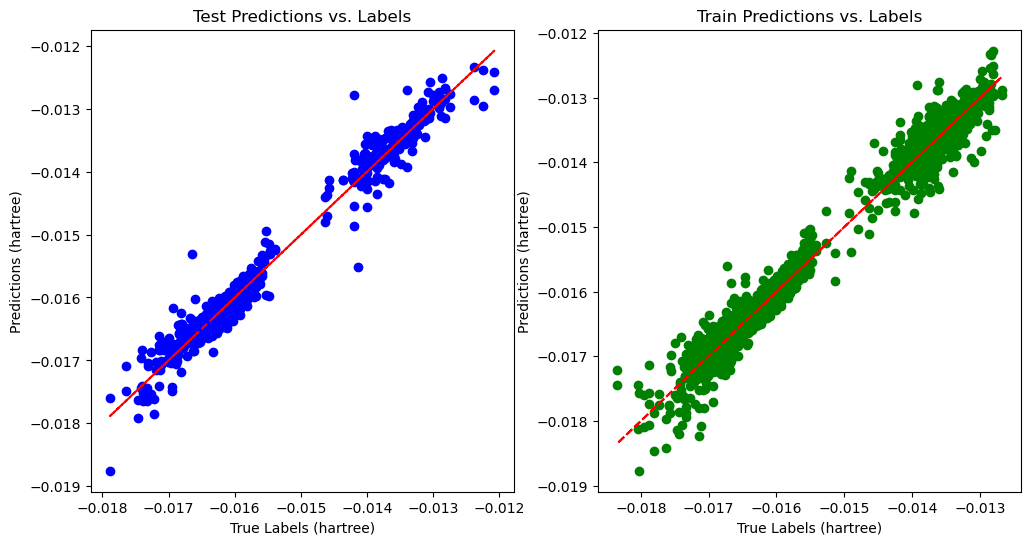

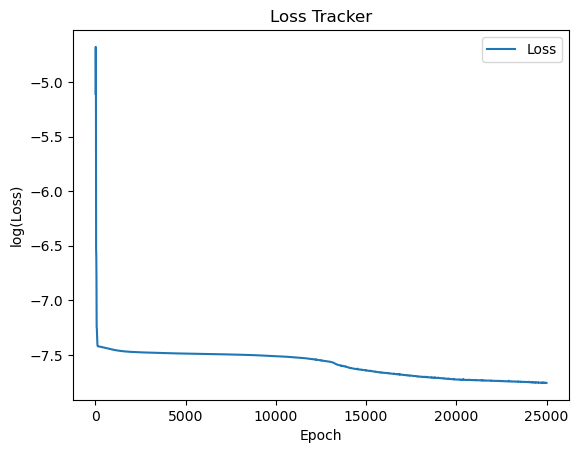

In [15]:
import matplotlib.pyplot as plt

trainpredictions=predict(trainselffeats, trainselfaddfeats)
testpredictions=predict(testfeats, testaddfeats)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot test predictions vs. labels
axs[0].scatter(testlabels, testpredictions,  color='blue', label='Test')
axs[0].plot(testlabels,testlabels, color='red',linestyle='--')
axs[0].set_title("Test Predictions vs. Labels")
axs[0].set_ylabel("Predictions (hartree)")
axs[0].set_xlabel("True Labels (hartree)")

# Plot train predictions vs. labels
axs[1].scatter(trainlabels, trainpredictions,  color='green', label='Train')
axs[1].plot(trainlabels,trainlabels, color='red',linestyle='--')
axs[1].set_title("Train Predictions vs. Labels")
axs[1].set_ylabel("Predictions (hartree)")
axs[1].set_xlabel("True Labels (hartree)")

# Display the plots
plt.savefig('alkane-self-training-test.png')
plt.show()

# Plot the loss tracker in a new figure
plt.figure()
plt.plot(losstracker.keys(), losstracker.values(), label='Loss')
plt.title("Loss Tracker")
plt.xlabel("Epoch")
plt.ylabel("log(Loss)")
plt.legend()

# Display the loss tracker plot
plt.savefig('alkane-self-training-loss.png')
plt.show()

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have the following arrays:
y_true = np.array(testlabels)       # Actual labels
y_pred = np.array(testpredictions)  # Predicted labels

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 4. Mean Absolute Percentage Error (MAPE)
# Note: MAPE can have issues with very small true values (y_true close to 0).
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# 5. R-squared (R²)
r2 = r2_score(y_true, y_pred)
print(f'R-squared (R²): {r2}')

# 6. Standard Deviation of Error (SDE)
# Residuals are the differences between true and predicted values
residuals = y_true - y_pred
sde = np.std(residuals)
print(f'Standard Deviation of Error (SDE): {sde}') 

print("ALKANE TEST SET")


Mean Absolute Error (MAE): 0.00012450686864270605
Mean Squared Error (MSE): 3.500982852049476e-08
Root Mean Squared Error (RMSE): 0.00018710913532079282
Mean Absolute Percentage Error (MAPE): 7.694671175575894%
R-squared (R²): 0.9733078040871158
Standard Deviation of Error (SDE): 0.001628087953356824
ALKANE TEST SET


In [19]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have the following arrays:
y_true = np.array(trainlabels)       # Actual labels
y_pred = np.array(trainpredictions)  # Predicted labels

# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# 2. Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 3. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# 4. Mean Absolute Percentage Error (MAPE)
# Note: MAPE can have issues with very small true values (y_true close to 0).
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# 5. R-squared (R²)
r2 = r2_score(y_true, y_pred)
print(f'R-squared (R²): {r2}')

# 6. Standard Deviation of Error (SDE)
# Residuals are the differences between true and predicted values
residuals = y_true - y_pred
sde = np.std(residuals)
print(f'Standard Deviation of Error (SDE): {sde}') 

print("ALKANE TRAIN SET")


Mean Absolute Error (MAE): 0.00011016843997517407
Mean Squared Error (MSE): 2.7365191213467727e-08
Root Mean Squared Error (RMSE): 0.0001654242763728097
Mean Absolute Percentage Error (MAPE): 7.725680391952043%
R-squared (R²): 0.9790886193772256
Standard Deviation of Error (SDE): 0.0016207167775597264
ALKANE TRAIN SET
